CNN classification using the cats and dogs dataset with image data augmentation

## Load dependent libraries

In [3]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

## Download dataset

In [5]:
#!wget --no-check-certificate \
#    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
#    -O "/tmp/cats-and-dogs.zip"

local_zip = '../data/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./tmp')
zip_ref.close()

In [7]:
print(len(os.listdir('./tmp/PetImages/Cat/')))
print(len(os.listdir('./tmp/PetImages/Dog/')))

12501
12501


In [8]:
try:
    os.mkdir('./tmp/cats-v-dogs')
    os.mkdir('./tmp/cats-v-dogs/training')
    os.mkdir('./tmp/cats-v-dogs/testing')
    os.mkdir('./tmp/cats-v-dogs/training/cats')
    os.mkdir('./tmp/cats-v-dogs/training/dogs')
    os.mkdir('./tmp/cats-v-dogs/testing/cats')
    os.mkdir('./tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

## Preprocess data

In [9]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[:testing_length]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "./tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "./tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "./tmp/cats-v-dogs/testing/cats/"

DOG_SOURCE_DIR = "./tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "./tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "./tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


## Number of images for training and testing

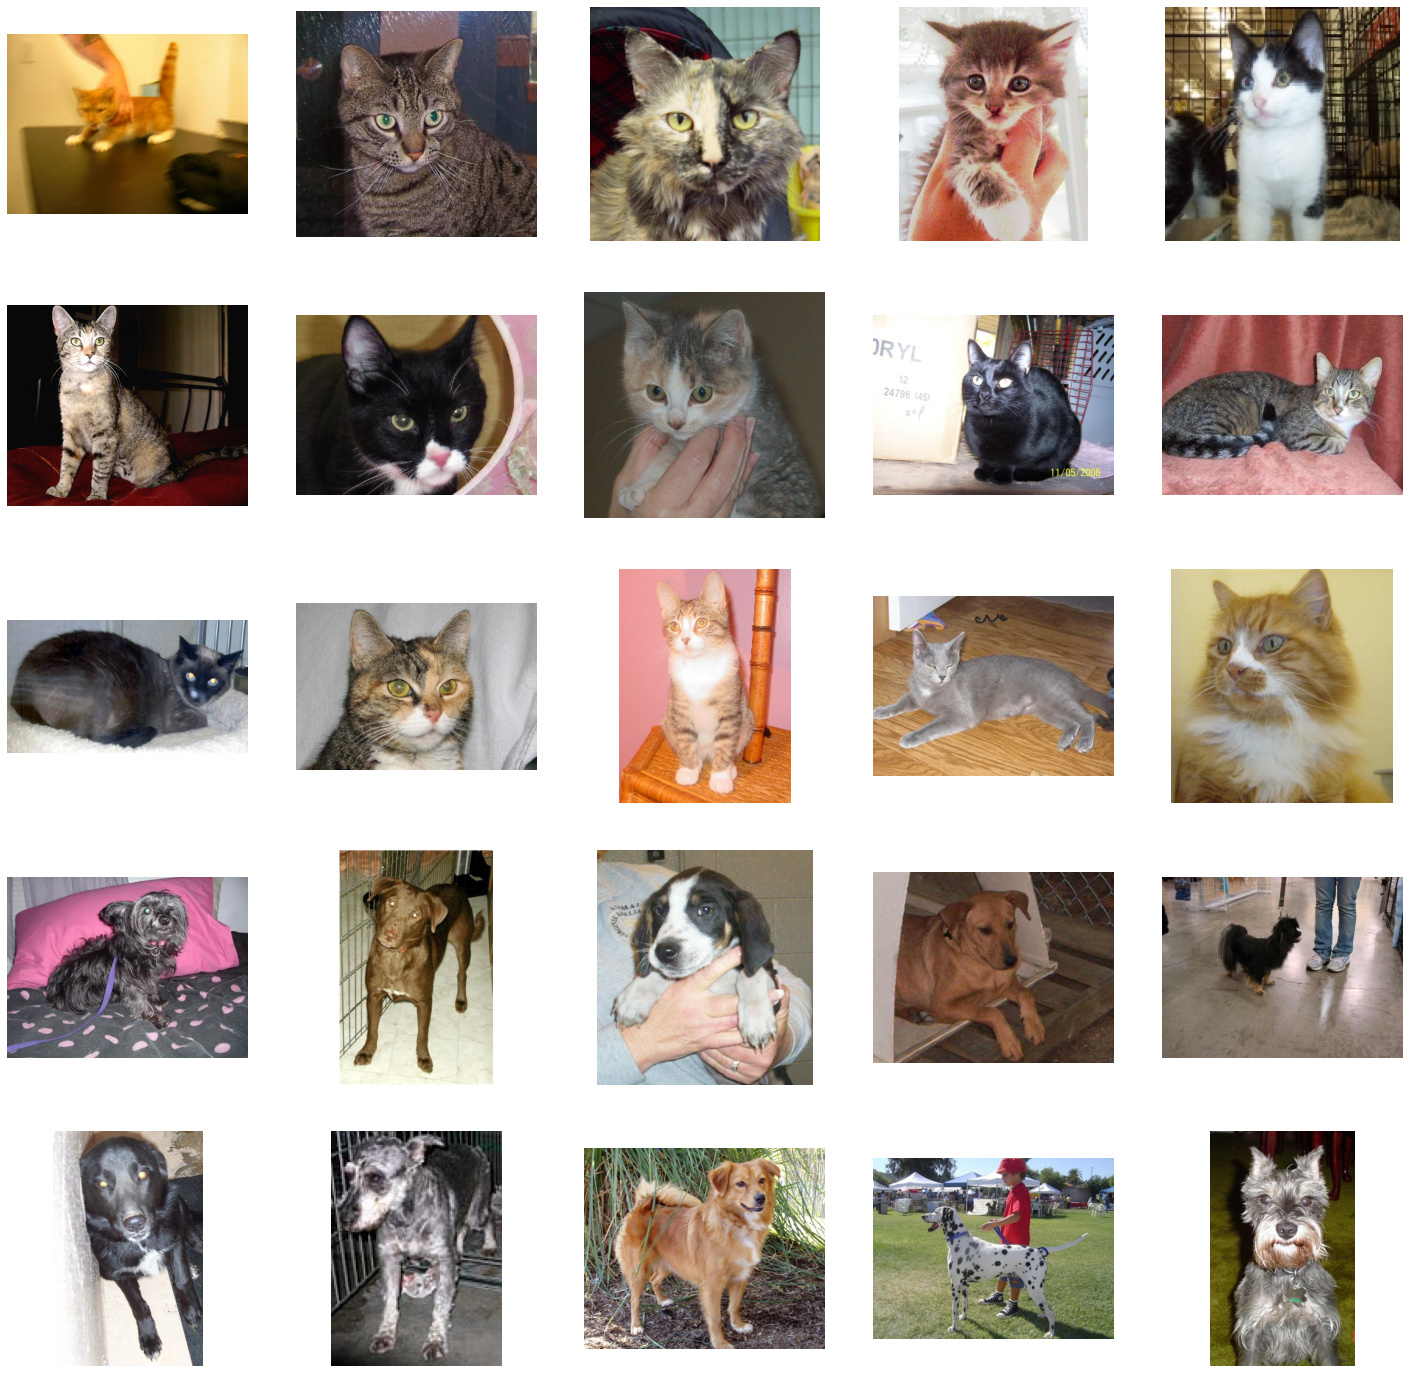

(366, 225, 3)


In [17]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 5x5 configuration
nrows = 5
ncols = 5

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 5x5 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 5, nrows * 5)

cat_fnames = os.listdir('./tmp/cats-v-dogs/training/cats/')
dog_fnames = os.listdir('./tmp/cats-v-dogs/training/dogs/')

fnames = ['%s/%s' % ('./tmp/cats-v-dogs/training/cats/', x) for x in cat_fnames[0:15]]
fnames = fnames + ['%s/%s' % ('./tmp/cats-v-dogs/training/dogs/', x) for x in dog_fnames[0:10]]

i = 0
for fname in fnames:
    sp = plt.subplot(nrows, ncols, i + 1)
    i += 1
    sp.axis('Off')
    img = mpimg.imread(fname)
    plt.imshow(img)

plt.show()
print(img.shape)

In [11]:
print(len(os.listdir('./tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('./tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('./tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('./tmp/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


## Display some images of cats and dogs

## Build and compile model

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

## Init the ImageDataGenerator for traning and validation

In [18]:
TRAINING_DIR = "./tmp/cats-v-dogs/training/"

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "./tmp/cats-v-dogs/testing/"

validation_datagen = ImageDataGenerator(rescale=1./255,
                                        rotation_range=40,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


## Fit the model

In [19]:
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
225/225 [==============================] - 226s 992ms/step - loss: 0.9280 - accuracy: 0.5489 - val_loss: 0.6110 - val_accuracy: 0.6648
Epoch 2/15
225/225 [==============================] - 120s 535ms/step - loss: 0.6341 - accuracy: 0.6397 - val_loss: 0.5740 - val_accuracy: 0.6952
Epoch 3/15
225/225 [==============================] - 120s 533ms/step - loss: 0.5890 - accuracy: 0.6862 - val_loss: 0.6106 - val_accuracy: 0.6692
Epoch 4/15
225/225 [==============================] - 119s 527ms/step - loss: 0.5687 - accuracy: 0.7073 - val_loss: 0.5248 - val_accuracy: 0.7308
Epoch 5/15
225/225 [==============================] - 120s 532ms/step - loss: 0.5380 - accuracy: 0.7224 - val_loss: 0.5330 - val_accuracy: 0.7280
Epoch 6/15
225/225 [==============================] - 117s 519ms/step - loss: 0.5191 - accuracy: 0.7434 - val_loss: 0.4786 - val_accuracy: 0.7668
Epoch 7/15
225/225 [==============================] - 117s 522ms/step - loss: 0.5008 - accuracy: 0.7560 - val_loss: 0.4835 -

<Figure size 432x288 with 0 Axes>

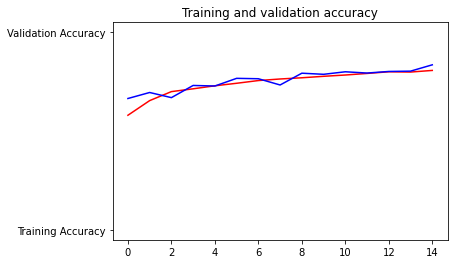

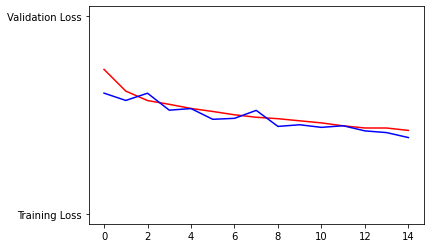

<Figure size 432x288 with 0 Axes>

In [20]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()